In [14]:
from IPython.display import set_matplotlib_formats
from jax.scipy.special import logsumexp
import matplotlib.pyplot as plt
from jax import random, vmap
import jax.numpy as jnp
import seaborn as sns
import pandas as pd
import numpy as np
import os

NAX = np.newaxis

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, SA
from numpyro import handlers

plt.style.use('bmh')
if "NUMPYRO_SPHINXBUILD" in os.environ:
    set_matplotlib_formats('svg')

#assert numpyro.__version__.startswith('0.6.0')
#numpyro.set_platform("gpu")

numpyro.set_platform("cpu")
#numpyro.set_host_device_count(5)

from scipy.integrate import simps
from jax.numpy import trapz

In [3]:
cd ..

/mnt/disk2/samarth/qdpy-numpyro


In [4]:
cd qdpy_jax

/mnt/disk2/samarth/qdpy-numpyro/qdpy_jax


### Creating a simple qdPy script to test out pyro

In [6]:
def eig_mcmc_func(warr):
    return  get_eigs(create_supermatrix(warr[0], warr, w5))/2./omega0
    

#def create_supermatrix(wsr_slope):
def create_supermatrix(w1, w3, w5):
    integrand1 = Tsr[0, :] * w1
    integrand3 = Tsr[1, :] * w3
    integrand5 = Tsr[2, :] * w5
    integral1 = trapz(integrand1, x=r)
    integral3 = trapz(integrand3, x=r)
    integral5 = trapz(integrand5, x=r)
    prod_gamma1 = gamma(ell1)*gamma(ell2)*gamma(s_arr[0])
    prod_gamma3 = gamma(ell1)*gamma(ell2)*gamma(s_arr[0])
    prod_gamma5 = gamma(ell1)*gamma(ell2)*gamma(s_arr[0])
    wpi = (wigvals[:, 0]*integral1*prod_gamma1 + 
           wigvals[:, 1]*integral3*prod_gamma3 +
           wigvals[:, 2]*integral5*prod_gamma5)
    #diag = minus1pow_vecm(m)*8*np.pi*omega0*(wigvals @ (prod_gammas * integral))
    #diag = minus1pow_vecm(m)*8*np.pi*omega0*wpi
    diag = 8*np.pi*omega0*wpi
    supmat = jnp.diag(diag)
    return supmat

def get_eigs(mat):
    eigvals, eigvecs = jnp.linalg.eigh(mat)
    return eigvals

def gamma(ell):
    return jnp.sqrt((2*ell+1)/4./np.pi)

def minus1pow_vecm(num):
    modval = num % 2
    retval = np.zeros_like(modval)
    retval[modval == 1] = -1
    retval[modval == 0] = 1
    return retval

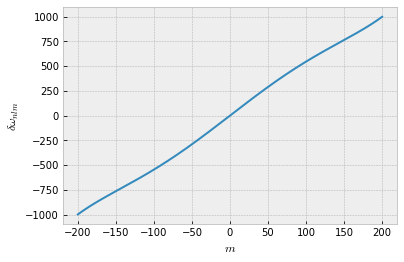

In [22]:
r = np.loadtxt('/mnt/disk2/samarth/qdpy-numpyro/qdpy_jax/r.dat')
U = np.loadtxt('/mnt/disk2/samarth/qdpy-numpyro/qdpy_jax/U3672.dat')
V = np.loadtxt('/mnt/disk2/samarth/qdpy-numpyro/qdpy_jax/V3672.dat')

rmin, rmax = 0.3, 1.0
rmin_idx = np.argmin(abs(r - rmin))
rmax_idx = np.argmin(abs(r - rmax)) + 1

r = r[rmin_idx:rmax_idx]
U = U[rmin_idx:rmax_idx]
V = V[rmin_idx:rmax_idx]

r = jnp.asarray(r)
U = jnp.asarray(U)
V = jnp.asarray(V)
Tsr = jnp.asarray(Tsr)

n1, n2 = 0, 0
ell1, ell2 = 200, 200
ell = min(ell1, ell2)
nu0 = 4741.

Msol = 1.989e33
Rsol = 6.956e10
B0 = 10.e5
OM = jnp.sqrt(4*np.pi*Rsol*B0**2/Msol)
nu0 /= OM*1e6
omega0 = 2*jnp.pi*nu0

s_arr = jnp.array([1., 3., 5.])
m = jnp.arange(-ell, ell+1)
wigvals = np.zeros((2*ell+1, len(s_arr)))
for i in range(len(s_arr)):
    wigvals[:, i] = w3j_vecm(ell1, s_arr[i], ell2, -m, 0*m, m)
    
wigvals = jnp.asarray(wigvals)
w1t, w3t, w5t = 10.51, .43, .175
eigvals_true = get_eigs(create_supermatrix(w1t, w3t, w5t))/2/omega0
eigvals_sigma = np.ones_like(eigvals_true)*1.0
eigvals_sigma = jnp.asarray(eigvals_sigma)

plt.figure()
plt.plot(m, eigvals_true)
plt.xlabel('$m$')
plt.ylabel('$\delta\omega_{nlm}$')
plt.show()



In [31]:
w1min, w1max = .1*abs(w1t), 3.*abs(w1t)
    w3min, w3max = .1*abs(w3t), 3.*abs(w3t)
    w5min, w5max = .1*abs(w5t), 3.*abs(w5t)
    wmin = np.array([w1min, w3min, w5min])
    wmax = np.array([w1max, w3max, w5max])

def model():
    # setting min and max value to be 0.1*true and 3.*true
    wlist = []
    
    for i in range(3):
        wlist.append(numpyro.sample(f'w{2*i+1}', dist.Uniform(wmin[i], wmax[i])))
    
    warr = jnp.asarray(wlist)
    #sigma = numpyro.sample('sigma', dist.Uniform(0.1, 10.0))
    eig_sample = numpyro.deterministic('eig', eig_mcmc_func(warr))
    obs = numpyro.factor('obs', dist.Normal(eig_sample, eigvals_sigma).log_prob(eigvals_true))
    #numpyro.sample('obs', dist.Normal(eig_sample, eigvals_sigma), obs=eigvals_true)
    return None

In [58]:
# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(12)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(model)
#kernel = SA(model)
mcmc = MCMC(kernel, num_warmup=50, num_samples=300)#, num_chains=5)

model_init = numpyro.infer.util.initialize_model(rng_key_, model, model_args=())

In [ ]:
mcmc.run(rng_key_)
#mcmc.run(rng_key_, x_scaled=x_scaled)
mcmc.print_summary()
print(f"w1_true = {w1t}\n" +
      f"w3_true = {w3t}\n" +
      f"w5_true = {w5t}")

warmup:  13%|█▎        | 46/350 [03:01<23:34,  4.65s/it, 1023 steps of size 2.23e-09. acc. prob=0.58]

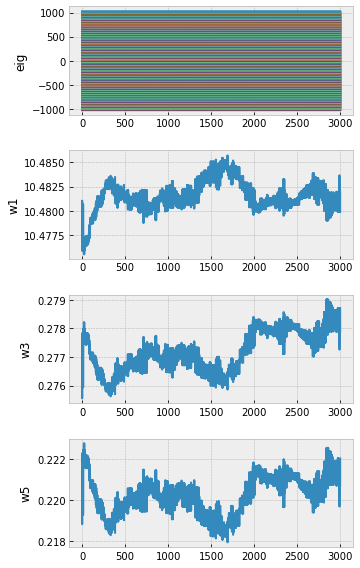

In [34]:
samples_1 = mcmc.get_samples()
fig, axs = plt.subplots(nrows=len(samples_1.keys()), ncols=1, figsize=(5, 8))
axs = axs.flatten()
count = 0
for key in samples_1.keys():
    axs[count].plot(samples_1[f'{key}'])
    axs[count].set_ylabel(f'{key}')
    count += 1
plt.tight_layout()

/mnt/disk2/samarth/anaconda3/envs/jax-gpu/lib/python3.8/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/mnt/disk2/samarth/anaconda3/envs/jax-gpu/lib/python3.8/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: invalid value encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5


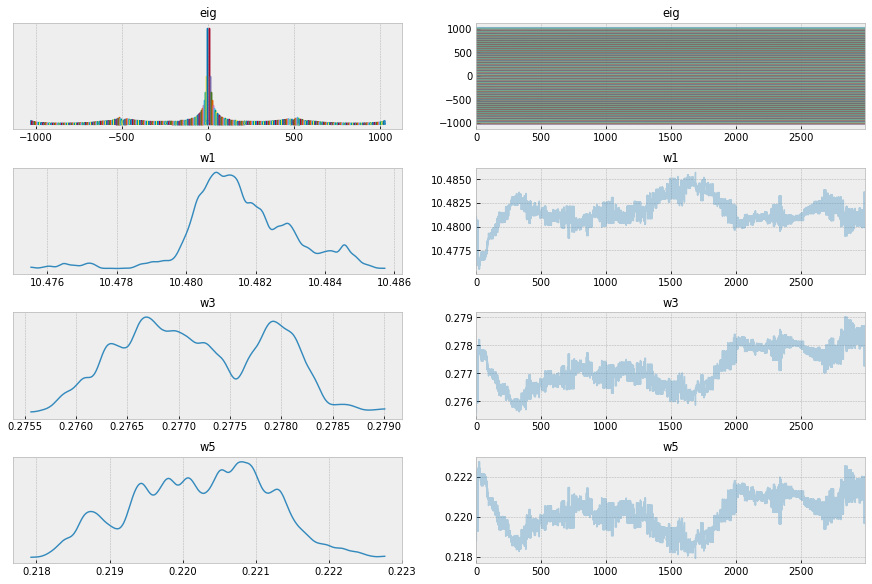

In [35]:
import arviz as az
data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True);

NameError: name 'eig_samples' is not defined

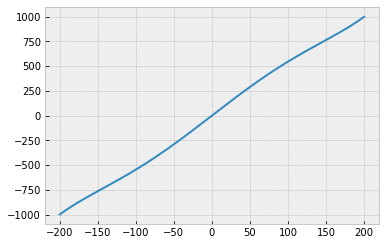

In [36]:
plt.figure()
plt.plot(m, eigvals_true)
for i in range(eig_samples.shape[0]):
    plt.plot(m, eig_samples[i, :], 'r', alpha=0.02)
plt.xlabel('$m$')
plt.ylabel('$\delta\omega_{nlm}$')
plt.show()